[![Lab Documentation and Solutions](https://img.shields.io/badge/Lab%20Documentation%20and%20Solutions-purple)](https://mongodb-developer.github.io/ai-agents-lab/)


# Step 1: Setup prerequisites

In [3]:
import os
import sys
from pymongo import MongoClient
from langchain.tools import tool
import voyageai
from typing import List
from typing import Annotated
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
# Add parent directory to path to import from utils
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))
from utils import track_progress, set_env
from utils import create_index, check_index_ready
from langchain_core.load import load
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from utils import get_llm
from langchain_core.messages import ToolMessage
from typing import Dict
from pprint import pprint
from langgraph.graph import StateGraph, START
from IPython.display import Image, display
from langgraph.graph import END

# If you are using your own MongoDB Atlas cluster, use the connection string for your cluster here
MONGODB_URI = os.environ.get("MONGODB_URI")
# Initialize a MongoDB Python client
mongodb_client = MongoClient(MONGODB_URI)
# Check the connection to the server
mongodb_client.admin.command("ping")
# Track progress of key steps-- DO NOT CHANGE
track_progress("cluster_creation", "ai_agents_mem_lab")

Tracking progress for task cluster_creation


In [ ]:
# Set the LLM provider and passkey provided by your workshop instructor
# NOTE: LLM_PROVIDER can be set to one of "aws"/ "microsoft" / "google"
LLM_PROVIDER = "aws"
PASSKEY = ""

In [5]:
# Obtain API keys from our AI model proxy and set them as environment variables-- DO NOT CHANGE
set_env([LLM_PROVIDER,"voyageai"], PASSKEY)

Successfully set AWS_ACCESS_KEY_ID environment variable.
Successfully set AWS_SECRET_ACCESS_KEY environment variable.
Successfully set VOYAGE_API_KEY environment variable.


### **Do not change the values assigned to the variables below**

In [6]:
import json
#  Database name
DB_NAME = "mongodb_genai_devday_agents"
# Name of the collection with full documents- used for summarization
FULL_COLLECTION_NAME = "mongodb_docs"
# Name of the collection for vector search- used for Q&A
VS_COLLECTION_NAME = "mongodb_docs_embeddings"
# Name of the vector search index
VS_INDEX_NAME = "vector_index"
# Connect to the `VS_COLLECTION_NAME` collection.
vs_collection = mongodb_client[DB_NAME][VS_COLLECTION_NAME]
# Connect to the `FULL_COLLECTION_NAME` collection.
full_collection = mongodb_client[DB_NAME][FULL_COLLECTION_NAME]
# Insert a dataset of MongoDB docs with embeddings into the `VS_COLLECTION_NAME` collection
with open(f"../data/{VS_COLLECTION_NAME}.json", "r") as data_file:
    json_data = data_file.read()

data = json.loads(json_data)

print(f"Deleting existing documents from the {VS_COLLECTION_NAME} collection.")
vs_collection.delete_many({})
vs_collection.insert_many(data)
print(
    f"{vs_collection.count_documents({})} documents ingested into the {VS_COLLECTION_NAME} collection."
)
# Insert a dataset of MongoDB documentation pages into the `FULL_COLLECTION_NAME` collection
with open(f"../data/{FULL_COLLECTION_NAME}.json", "r") as data_file:
    json_data = data_file.read()

data = json.loads(json_data)

print(f"Deleting existing documents from the {FULL_COLLECTION_NAME} collection.")
full_collection.delete_many({})
full_collection.insert_many(data)
print(
    f"{full_collection.count_documents({})} documents ingested into the {FULL_COLLECTION_NAME} collection."
)
# Create vector index definition specifying:
# path: Path to the embeddings field
# numDimensions: Number of embedding dimensions- depends on the embedding model used
# similarity: Similarity metric. One of cosine, euclidean, dotProduct.
model = {
    "name": VS_INDEX_NAME,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 1024,
                "similarity": "cosine",
            }
        ]
    },
}
create_index(vs_collection, VS_INDEX_NAME, model)
# Use the `check_index_ready` function from the `utils` module to verify that the index was created and is in READY status before proceeding
check_index_ready(vs_collection, VS_INDEX_NAME)
# Track progress of key steps-- DO NOT CHANGE
track_progress("vs_index_creation", "ai_agents_lab")
# Initialize the Voyage AI client
vo = voyageai.Client()

Deleting existing documents from the mongodb_docs_embeddings collection.
101 documents ingested into the mongodb_docs_embeddings collection.
Deleting existing documents from the mongodb_docs collection.
20 documents ingested into the mongodb_docs collection.
Creating the vector_index index
vector_index index status: READY
vector_index index definition: {'fields': [{'type': 'vector', 'path': 'embedding', 'numDimensions': 1024, 'similarity': 'cosine'}]}
Tracking progress for task vs_index_creation


# Step 2: Functions and retrieval tools

In [7]:
def get_embeddings(query: str) -> List[float]:
    """
    Get embeddings for an input query.

    Args:
        query (str): Query string

    Returns:
        List[float]: Embedding of the query string
    """
    # Use the `contextualized_embed` method of the Voyage AI API to embed the user query with the following arguments:
    # inputs: `query` wrapped in a list of lists
    # model: `voyage-context-3`
    # input_type: "query"
    embds_obj = vo.contextualized_embed(inputs=[[query]], model="voyage-context-3", input_type="query")
    # Extract embeddings from the embeddings object
    embeddings = embds_obj.results[0].embeddings[0]
    return embeddings
# Define a tool to retrieve relevant documents for a user query using vector search
@tool
def get_information_for_question_answering(user_query: str) -> str:
    """
    Retrieve information using vector search to answer a user query.

    Args:
    user_query (str): The user's query string.

    Returns:
    str: The retrieved information formatted as a string.
    """

    # Generate embeddings for the `user_query` using the `get_embeddings` function defined above
    query_embedding = get_embeddings(user_query)

    # Define an aggregation pipeline consisting of a $vectorSearch stage, followed by a $project stage
    # Set the number of candidates to 150 and only return the top 5 documents from the vector search
    # In the $project stage, exclude the `_id` field and include only the `body` field and `vectorSearchScore`
    # NOTE: Use variables defined previously for the `index`, `queryVector` and `path` fields in the $vectorSearch stage
    pipeline = [
        {
            "$vectorSearch": {
                "index": VS_INDEX_NAME,
                "path": "embedding",
                "queryVector": query_embedding,
                "numCandidates": 150,
                "limit": 5,
            }
        },
        {
            "$project": {
                "_id": 0,
                "body": 1,
                "score": {"$meta": "vectorSearchScore"},
            }
        },
    ]

    # Execute the aggregation `pipeline` against the `vs_collection` collection and store the results in `results`
    results = vs_collection.aggregate(pipeline)
    # Concatenate the results into a string
    context = "\n\n".join([doc.get("body") for doc in results])
    return context
# Define a tool to retrieve the content of a documentation page for summarization
@tool
def get_page_content_for_summarization(user_query: str) -> str:
    """
    Retrieve page content based on provided title.

    Args:
    user_query (str): The user's query string i.e. title of the documentation page.

    Returns:
    str: The content of the page.
    """
    # Query the documents where the `title` field is equal to the `user_query`
    query = {"title": user_query}
    # Only return the `body` field from the retrieved documents.
    # NOTE: Set fields to include to 1, those to exclude to 0. `_id` is included by default, so exclude that.
    projection = {"_id": 0, "body": 1}
    # Use the `query` and `projection` with the `find_one` method
    # to get the `body` of the document with `title` equal to the `user_query` from the `full_collection` collection
    document = full_collection.find_one(query, projection)
    if document:
        return document["body"]
    else:
        return "Document not found"
# Create the list of tools
tools = [
    get_information_for_question_answering,
    get_page_content_for_summarization,
]

# Step 3: Graph State and Prompt

In [8]:
# Define the graph state
# We are only tracking chat messages but you can track other attributes as well
class GraphState(TypedDict):
    messages: Annotated[list, add_messages]
# Obtain the Langchain LLM object using the `get_llm` function from the `utils`` module.
llm = get_llm(LLM_PROVIDER)
# Create a Chain-of-Thought (CoT) prompt template for the agent.
# This includes a system prompt with a placeholder for tool names, and a placeholder for messages i.e. user queries and assistant responses
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "You are a helpful AI assistant."
            " You are provided with tools to answer questions and summarize technical documentation related to MongoDB."
            " Think step-by-step and use these tools to get the information required to answer the user query."
            " Do not re-run tools unless absolutely necessary."
            " If you are not able to get enough information using the tools, reply with I DON'T KNOW."
            " You have access to the following tools: {tool_names}."
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
# Fill in the prompt template with the tool names
prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
# Bind the `tools` to the `llm` instantiated above
bind_tools = llm.bind_tools(tools)
# Chain the `prompt` with the tool-augmented llm using the `|` operator
llm_with_tools = prompt | bind_tools

# Step 4: Define graph nodes and compile 

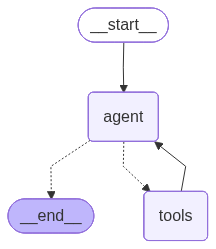

In [9]:
# Define the agent node
def agent(state: GraphState) -> Dict[str, List]:
    """
    Agent node

    Args:
        state (GraphState): Graph state

    Returns:
        Dict[str, List]: Updates to messages
    """
    # Get the messages from the graph `state`
    messages = state["messages"]
    # Invoke `llm_with_tools` with `messages` using the `invoke` method
    # HINT: See Step 6 for how to invoke `llm_with_tools`
    result = llm_with_tools.invoke(messages)
    # Write `result` to the `messages` attribute of the graph state
    return {"messages": [result]}
# Create a map of tool name to tool call
tools_by_name = {tool.name: tool for tool in tools}
# Define tool node
def tool_node(state: GraphState) -> Dict[str, List]:
    """
    Tool node

    Args:
        state (GraphState): Graph state

    Returns:
        Dict[str, List]: Updates to messages
    """
    result = []
    # Get the list of tool calls from messages
    tool_calls = state["messages"][-1].tool_calls
    # A tool_call looks as follows:
    # {
    #     "name": "get_information_for_question_answering",
    #     "args": {"user_query": "What are Atlas Triggers"},
    #     "id": "call_H5TttXb423JfoulF1qVfPN3m",
    #     "type": "tool_call",
    # }
    # Iterate through `tool_calls`
    for tool_call in tool_calls:
        # Get the tool from `tools_by_name` using the `name` attribute of the `tool_call`
        tool = tools_by_name[tool_call["name"]]
        # Invoke the `tool` using the `args` attribute of the `tool_call`
        # HINT: See previous line to see how to extract attributes from `tool_call`
        observation = tool.invoke(tool_call["args"])
        # Append the result of executing the tool to the `result` list as a ToolMessage
        # The `content` of the message is `observation` i.e. result of the tool call
        # The `tool_call_id` can be obtained from the `tool_call`
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    # Write `result` to the `messages` attribute of the graph state
    return {"messages": result}
# Define conditional routing function
def route_tools(state: GraphState):
    """
    Use in the conditional_edge to route to the tool node if the last message
    has tool calls. Otherwise, route to the end.
    """
    # Get messages from graph state
    messages = state.get("messages", [])
    if len(messages) > 0:
        # Get the last AI message from messages
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    # Check if the last message has tool calls
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # If yes, return "tools"
        return "tools"
    # If no, return END
    return END
# Instantiate the graph
graph = StateGraph(GraphState)
# Add nodes to the `graph` using the `add_node` function
# Add a `agent` node. The `agent` node should run the `agent` function
graph.add_node("agent", agent)
# Add a `tools` node. The `tools` node should run the `tool_node` function
graph.add_node("tools", tool_node)
# Add fixed edges to the `graph` using the `add_edge` method
# Add an edge from the START node to the `agent` node
graph.add_edge(START, "agent")
# Add an edge from the `tools` node to the `agent` node
graph.add_edge("tools", "agent")
# Use the `add_conditional_edges` method to add a conditional edge from the `agent` node to the `tools` node
# based on the output of the `route_tools` function
graph.add_conditional_edges(
    "agent",
    route_tools,
    {"tools": "tools", END: END},
)
# Compile the `graph`
app = graph.compile()
app

In [10]:
def execute_graph(user_input: str) -> None:
    """
    Stream outputs from the graph

    Args:
        user_input (str): User query string
    """
    # Stream outputs from each step in the graph
    for step in app.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        # Stream full value of the state after each step
        stream_mode="values",
    ):
        # Print the latest message from the step
        step["messages"][-1].pretty_print()

#  Step 5: Execute the graph with Short or Long term memory

In [11]:
# Test the graph execution to view end-to-end flow
execute_graph("What are some best practices for data backups in MongoDB?")

================================ Human Message =================================

What are some best practices for data backups in MongoDB?
================================== Ai Message ==================================

I'll help you find information about best practices for data backups in MongoDB.
Tool Calls:
  get_information_for_question_answering (toolu_bdrk_01BQKbKD2AFa7PZKwFzswJJf)
 Call ID: toolu_bdrk_01BQKbKD2AFa7PZKwFzswJJf
  Args:
    user_query: best practices for data backups in MongoDB
================================= Tool Message =================================

# Backup and Restore Sharded Clusters

The following tutorials describe backup and restoration for sharded clusters:

To use `mongodump` and `mongorestore` as a backup strategy for sharded clusters, you must stop the sharded cluster balancer and use the `fsync` command or the `db.fsyncLock()` method on `mongos` to block writes on the cluster during backups.

Sharded clusters can also use one of the following

In [12]:
execute_graph("What did I just ask you?")

================================ Human Message =================================

What did I just ask you?
================================== Ai Message ==================================

You just asked me: "What did I just ask you?"

This is a self-referential question where you're asking me to repeat back the question you just posed to me.


# Step 6: Add Session memory (Short term) to the agent

In [13]:
from langgraph.checkpoint.mongodb import MongoDBSaver

In [14]:
# Initialize a MongoDB checkpointer
checkpointer = MongoDBSaver(mongodb_client)

In [15]:
# Instantiate the graph with the checkpointer
app = graph.compile(checkpointer=checkpointer)

📚 https://langchain-ai.github.io/langgraph/concepts/persistence/#threads

In [16]:
def execute_graph_with_memory(thread_id: str, user_input: str) -> None:
    """
    Stream outputs from the graph

    Args:
        thread_id (str): Thread ID for the checkpointer
        user_input (str): User query string
    """
    # Create a runtime config for the thread ID `thread_id`
    config = {"configurable": {"thread_id": thread_id}}
    # Stream outputs from each step in the graph
    for step in app.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        # Pass the config as an additional parameter
        config,
        stream_mode="values",
    ):
        # Print the latest message from the step
        step["messages"][-1].pretty_print()

In [17]:
# Test graph execution with thread ID
execute_graph_with_memory(
    "1",
    "What are some best practices for data backups in MongoDB?",
)

================================ Human Message =================================

What are some best practices for data backups in MongoDB?
================================== Ai Message ==================================

I'll help you find information about best practices for data backups in MongoDB.
Tool Calls:
  get_information_for_question_answering (toolu_bdrk_01JWBUNeg3XTQkJfJ5pGk5CY)
 Call ID: toolu_bdrk_01JWBUNeg3XTQkJfJ5pGk5CY
  Args:
    user_query: best practices for data backups in MongoDB
================================= Tool Message =================================

# Backup and Restore Sharded Clusters

The following tutorials describe backup and restoration for sharded clusters:

To use `mongodump` and `mongorestore` as a backup strategy for sharded clusters, you must stop the sharded cluster balancer and use the `fsync` command or the `db.fsyncLock()` method on `mongos` to block writes on the cluster during backups.

Sharded clusters can also use one of the following

In [18]:
# Follow-up question to ensure message history works
execute_graph_with_memory(
    "1",
    "What did I just ask you?",
)

================================ Human Message =================================

What did I just ask you?
================================== Ai Message ==================================

You just asked me: "What are some best practices for data backups in MongoDB?"


In [19]:
execute_graph_with_memory(
    2,
    "Hi! I'm a senior DBA focusing on disaster recovery and backup strategies. Can you tell me about backup and restore?"
)

================================ Human Message =================================

Hi! I'm a senior DBA focusing on disaster recovery and backup strategies. Can you tell me about backup and restore?
================================== Ai Message ==================================

I'll help you with information about backup and restore strategies in MongoDB. Let me retrieve the relevant documentation for you.
Tool Calls:
  get_information_for_question_answering (toolu_bdrk_01GfVo6A8G4FfBtqJfnu5zjw)
 Call ID: toolu_bdrk_01GfVo6A8G4FfBtqJfnu5zjw
  Args:
    user_query: backup and restore strategies disaster recovery
================================= Tool Message =================================

# Backup and Restore Sharded Clusters

The following tutorials describe backup and restoration for sharded clusters:

To use `mongodump` and `mongorestore` as a backup strategy for sharded clusters, you must stop the sharded cluster balancer and use the `fsync` command or the `db.fsyncLock()` meth

# Will this tailor the response for the role?

In [21]:
execute_graph_with_memory(
    2,
    "Can you tell me about MongoDB operations?"
)

================================ Human Message =================================

Can you tell me about MongoDB operations?
================================== Ai Message ==================================

Let me retrieve information about MongoDB operations for you.
Tool Calls:
  get_information_for_question_answering (toolu_bdrk_014uKwNq11yHx9oYNnrcAhxU)
 Call ID: toolu_bdrk_014uKwNq11yHx9oYNnrcAhxU
  Args:
    user_query: MongoDB operations administration maintenance management
================================= Tool Message =================================

# Configuration and Maintenance

This section describes routine management operations, including updating your MongoDB deployment's configuration.

Outlines common MongoDB configurations and examples of best-practice configurations for common use cases.

Upgrade a MongoDB deployment to a different patch release within the same major release series.

Start, configure, and manage running `mongod` process.

Stop in progress MongoDB

# Long-Term Memory Implementation: Hot Path (Memory Tools)

This implementation uses **Memory Tools** (`create_manage_memory_tool` and `create_search_memory_tool`) 
which allow the agent to **consciously** manage its own long-term memory.

## How it works:
1. The agent has access to `manage_memory` tool to save important user information
2. The agent has access to `search_memory` tool to retrieve relevant memories
3. Memories persist in MongoDB and survive across conversation threads

## References:
- [LangMem Hot Path Quickstart](https://langchain-ai.github.io/langmem/hot_path_quickstart/)
- [LangMem Memory Tools Reference](https://langchain-ai.github.io/langmem/reference/tools/)

# Step 7: langmem inports

In [22]:
# =============================================================================
# IMPORTS FOR LONG-TERM MEMORY (HOT PATH)
# =============================================================================

import time
from langmem import create_search_memory_tool
from langgraph.store.mongodb import MongoDBStore, create_vector_index_config
from langchain_voyageai import VoyageAIEmbeddings

In [23]:
# Drop the memories collection
mongodb_client["mongodb_genai_devday_agents"]["memories"].drop()
print("Collection dropped")

Collection dropped


# Monkey Patch for [Issue 138](https://github.com/langchain-ai/langmem/issues/138) in langmem

In [24]:
# =============================================================================
# MONKEY-PATCH: HOT PATH TO INCLUDE "kind" FIELD
# Add this AFTER imports, BEFORE creating memory tools
# =============================================================================

from langmem.knowledge.tools import _get_store, _ensure_json_serializable
from langmem import utils
from langchain_core.tools import StructuredTool
import typing
import uuid

def create_manage_memory_tool(
    namespace: tuple[str, ...] | str,
    *,
    instructions: str = "Proactively call this tool when you:\n\n"
    "1. Identify a new USER preference.\n"
    "2. Receive an explicit USER request to remember something or otherwise alter your behavior.\n"
    "3. Are working and want to record important context.\n"
    "4. Identify that an existing MEMORY is incorrect or outdated.\n",
    schema: typing.Type = str,
    actions_permitted: tuple = ("create", "update", "delete"),
    store = None,
    name: str = "manage_memory",
):
    """Drop-in replacement for langmem.create_manage_memory_tool with cold path compatibility."""
    
    namespacer = utils.NamespaceTemplate(namespace)
    action_type = typing.Literal[actions_permitted]
    default_action = "create" if "create" in actions_permitted else actions_permitted[0]
    initial_store = store
    
    # Get schema name for "kind" field
    schema_name = schema.__name__ if hasattr(schema, "__name__") else "Memory"

    async def amanage_memory(
        content: typing.Optional[schema] = None,
        action: action_type = default_action,
        *,
        id: typing.Optional[uuid.UUID] = None,
    ):
        store = _get_store(initial_store)
        if action not in actions_permitted:
            raise ValueError(f"Invalid action {action}. Must be one of {actions_permitted}.")
        if action == "create" and id is not None:
            raise ValueError("Cannot provide ID when creating a memory.")
        if action in ("delete", "update") and not id:
            raise ValueError("Must provide ID when deleting or updating.")
        
        ns = namespacer()
        if action == "delete":
            await store.adelete(ns, key=str(id))
            return f"Deleted memory {id}"

        id = id or uuid.uuid4()
        # PATCHED: Include "kind" for cold path compatibility
        await store.aput(
            ns,
            key=str(id),
            value={
                "kind": schema_name,
                "content": _ensure_json_serializable(content)
            },
        )
        return f"{action}d memory {id}"

    def manage_memory(
        content: typing.Optional[schema] = None,
        action: action_type = default_action,
        *,
        id: typing.Optional[uuid.UUID] = None,
    ):
        store = _get_store(initial_store)
        if action not in actions_permitted:
            raise ValueError(f"Invalid action {action}. Must be one of {actions_permitted}.")
        if action == "create" and id is not None:
            raise ValueError("Cannot provide ID when creating a memory.")
        if action in ("delete", "update") and not id:
            raise ValueError("Must provide ID when deleting or updating.")
        
        ns = namespacer()
        if action == "delete":
            store.delete(ns, key=str(id))
            return f"Deleted memory {id}"

        id = id or uuid.uuid4()
        # PATCHED: Include "kind" for cold path compatibility
        store.put(
            ns,
            key=str(id),
            value={
                "kind": schema_name,
                "content": _ensure_json_serializable(content)
            },
        )
        return f"{action}d memory {id}"

    description = f"""Create, update, or delete a memory.
Include the MEMORY ID when updating or deleting. Omit when creating.
{instructions}"""

    return StructuredTool.from_function(
        manage_memory, amanage_memory, name=name, description=description
    )

print("Hot path patched to include 'kind' field")

Hot path patched to include 'kind' field


# Step 8: Setup MongoDB Store for long term memory

In [51]:
# =============================================================================
# SETUP MONGODB STORE FOR LONG-TERM MEMORY
# =============================================================================

MEMORY_DB_NAME = "mongodb_genai_devday_agents"
MEMORY_COLLECTION_NAME = "memories"

# Get collection reference for direct queries
memory_collection = mongodb_client[MEMORY_DB_NAME][MEMORY_COLLECTION_NAME]

# Create vector index configuration for semantic search
memory_index_config = create_vector_index_config(
    dims=1024,
    embed=VoyageAIEmbeddings(model="voyage-3"),
    fields=["content"],
    name="memory_vector_index"
)

# Initialize MongoDBStore with collection object (NOT from_conn_string)
# IMPORTANT: from_conn_string() returns a context manager, not a store object
memory_store = MongoDBStore(
    collection=memory_collection,
    index_config=memory_index_config
)

print(f"MongoDBStore initialized for {MEMORY_DB_NAME}.{MEMORY_COLLECTION_NAME}")

MongoDBStore initialized for mongodb_genai_devday_agents.memories


# Step 9: Create hot path tools

In [52]:
# Tool for saving/updating/deleting memories

manage_memory_tool = create_manage_memory_tool(
    namespace=("memories", "{langgraph_user_id}"), 
     store=memory_store, # User-scoped memories
     actions_permitted=("create",), 
   
)

# Tool for searching memories
search_memory_tool = create_search_memory_tool(
   namespace=("memories", "{langgraph_user_id}"),
   store= memory_store
)

print(" Memory tools created:")
print(f"   - {manage_memory_tool.name}: Save/update/delete memories")
print(f"   - {search_memory_tool.name}: Search existing memories")

 Memory tools created:
   - manage_memory: Save/update/delete memories
   - search_memory: Search existing memories


In [53]:
# =============================================================================
# COMBINE ORIGINAL TOOLS WITH MEMORY TOOLS
# =============================================================================


#To avoid adding duplicates when re-executing the cell
tools = tools + [t for t in [manage_memory_tool, search_memory_tool] if t.name not in [x.name for x in tools]]


tools_by_name = {tool.name: tool for tool in tools}
print(f"✅ Total tools available: {len(tools)}")
for tool in tools:
    print(f"   - {tool.name}")

✅ Total tools available: 4
   - get_information_for_question_answering
   - get_page_content_for_summarization
   - manage_memory
   - search_memory


# Step 9: Create LLM prompt with memory tools

In [54]:
# =============================================================================
# CREATE MEMORY-AWARE PROMPT
# This prompt instructs the agent to use memory tools
# =============================================================================

memory_aware_prompt = ChatPromptTemplate.from_messages(
    [
       (
    "system",
    """You are a helpful AI assistant with persistent memory capabilities.
You can answer questions about MongoDB documentation using your tools.

## MANDATORY FIRST ACTION:
Before responding to ANY user message, you MUST call search_memory first.
Do not skip this step. Do not assume you know the user.

## CRITICAL RULES:
- You have ZERO memory of users unless search_memory returns it
- NEVER say "I remember" or "You told me" without calling search_memory first
- If search_memory returns empty, respond with "I don't have any information about you yet"

## MEMORY INSTRUCTIONS:
1. FIRST: Always call search_memory with a relevant query
2. THEN: If user shares personal info, use manage_memory to save it
3. Acknowledge when you save something to memory

## PERSONALIZATION:
Based on search_memory results:
- Match technical depth to user's expertise level
- Focus on topics relevant to their role
- Reference their interests naturally

## TOOL USAGE:
- Do NOT call the same tool more than 2 times
- Use documentation tools for technical questions

Available tools: {tool_names}

REMEMBER: Your FIRST tool call must ALWAYS be search_memory."""
),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# Fill in tool names
memory_aware_prompt = memory_aware_prompt.partial(
    #tool_names=", ".join([tool.name for tool in tools_with_memory])
    tool_names=", ".join([tool.name for tool in tools])
)

print(" Memory-aware prompt created")

 Memory-aware prompt created


In [55]:
# =============================================================================
# CREATE MEMORY-AWARE LLM CHAIN
# =============================================================================

llm_with_tools = memory_aware_prompt | llm.bind_tools(tools)

print("✅ LLM chain with memory tools created")

✅ LLM chain with memory tools created


In [56]:
##Recompile the graph with memory_store
app_with_memory = graph.compile(
    checkpointer=checkpointer,  # Short-term memory (conversation history)
    store=memory_store          # Long-term memory (persistent memories)
)

print("Memory-aware graph compiled with:")
print("   - Checkpointer: Short-term memory (conversation threads)")
print("   - Store: Long-term memory (persistent user memories)")

Memory-aware graph compiled with:
   - Checkpointer: Short-term memory (conversation threads)
   - Store: Long-term memory (persistent user memories)


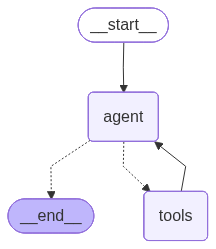

In [57]:
# =============================================================================
# VISUALIZE THE MEMORY-AWARE GRAPH
# =============================================================================

app_with_memory

In [58]:
# =============================================================================
# EXECUTION FUNCTION WITH MEMORY
# =============================================================================

def run_agent_with_memory(thread_id: str, user_id: str, user_input: str):
    """
    Execute the memory-aware agent.
    
    Args:
        thread_id: Unique conversation thread ID (short-term memory)
        user_id: User identifier for memory scoping (long-term memory)
        user_input: User's message
    """
    # Config with both thread_id and langgraph_user_id
    # IMPORTANT: langgraph_user_id must match the namespace pattern {langgraph_user_id}
    config = {
        "configurable": {
            "thread_id": thread_id,
            "langgraph_user_id": user_id,  # Required for memory namespace
        }
    }
    
    print(f"\n{'='*60}")
    print(f"Thread: {thread_id} | User: {user_id}")
    print(f"Input: {user_input}")
    print(f"{'='*60}\n")
    
    # Stream the response
    for step in app_with_memory.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config,
        stream_mode="values",
    ):
        msg = step["messages"][-1]
        if hasattr(msg, 'pretty_print'):
            msg.pretty_print()
        else:
            print(msg)

In [ ]:
# Drop the checkpointing collection to start fresh
#mongodb_client["checkpointing_db"]["checkpoints"].drop()
#print("Checkpoints cleared")

Checkpoints cleared


## Test 1: Save User Information to Memory

In this test, the user introduces themselves. The agent should:
1. Recognize this is personal information
2. Use `manage_memory` tool to save it
3. Acknowledge that it saved the information

In [60]:
# =============================================================================
# TEST 1: User introduces themselves - Agent should save to memory
# =============================================================================

run_agent_with_memory(
    "session-0001",
    "user-00001",
    "Hi! I'm a senior DBA focusing on disaster recovery and backup strategies."
)


Thread: session-0001 | User: user-00001
Input: Hi! I'm a senior DBA focusing on disaster recovery and backup strategies.

================================ Human Message =================================

Hi! I'm a senior DBA focusing on disaster recovery and backup strategies.
================================== Ai Message ==================================
Tool Calls:
  search_memory (toolu_bdrk_01QECRdHwDmxG3g6CrDP6ggA)
 Call ID: toolu_bdrk_01QECRdHwDmxG3g6CrDP6ggA
  Args:
    query: user profile role expertise DBA disaster recovery backup
================================= Tool Message =================================

[]
================================== Ai Message ==================================
Tool Calls:
  manage_memory (toolu_bdrk_01XPBbQjBWDZFrXD4H4pD1rK)
 Call ID: toolu_bdrk_01XPBbQjBWDZFrXD4H4pD1rK
  Args:
    action: create
    content: User is a senior DBA (Database Administrator) with a focus on disaster recovery and backup strategies. This indicates advanced technic

In [61]:
# =============================================================================
# VERIFY: Check if memory was saved to MongoDB
# =============================================================================


print("=== Checking MongoDB for saved memories ===")
print(f"\nCollection: {MEMORY_DB_NAME}.{MEMORY_COLLECTION_NAME}")

# Query memories for user-123
user_memories = list(memory_collection.find({}))
print(f"\nTotal documents in collection: {len(user_memories)}")

for doc in user_memories:
    print(f"\n--- Memory Document ---")
    print(f"Namespace: {doc.get('namespace', 'N/A')}")
    print(f"Key: {doc.get('key', 'N/A')}")
    print(f"Value: {doc.get('value', 'N/A')}")

=== Checking MongoDB for saved memories ===

Collection: mongodb_genai_devday_agents.memories

Total documents in collection: 1

--- Memory Document ---
Namespace: ['memories', 'user-00001']
Key: d0a39b2a-6e8d-45b8-a5eb-c5c22562a331
Value: {'kind': 'str', 'content': 'User is a senior DBA (Database Administrator) with a focus on disaster recovery and backup strategies. This indicates advanced technical expertise and interest in high availability, data protection, backup/restore procedures, and business continuity planning.'}


## Test 2: New Conversation Thread Recalls Memory

In this test, we start a NEW conversation thread but with the SAME user.
The agent should:
1. Search for existing memories about this user
2. Find the previously saved information
3. Use that context to personalize the response

In [62]:
# =============================================================================
# TEST 2: New thread, same user - Agent should recall memory
# =============================================================================

run_agent_with_memory(
    "session-00002",  # NEW thread
    "user-00001",        # SAME user
    "What do you know about me?"
)


Thread: session-00002 | User: user-00001
Input: What do you know about me?

================================ Human Message =================================

What do you know about me?
================================== Ai Message ==================================
Tool Calls:
  search_memory (toolu_bdrk_01G6BoMkpbF6HBhJpgSwCWCt)
 Call ID: toolu_bdrk_01G6BoMkpbF6HBhJpgSwCWCt
  Args:
    query: user information preferences background
================================= Tool Message =================================

[{"namespace":["memories","user-00001"],"key":"d0a39b2a-6e8d-45b8-a5eb-c5c22562a331","value":{"kind":"str","content":"User is a senior DBA (Database Administrator) with a focus on disaster recovery and backup strategies. This indicates advanced technical expertise and interest in high availability, data protection, backup/restore procedures, and business continuity planning."},"created_at":"2026-01-06T00:05:01.108000","updated_at":"2026-01-06T00:05:01.108000","score":0.639022

## Test 3: Technical Question with User Context

Ask a technical question. The agent should:
1. Recall that the user is a DBA focused on disaster recovery
2. Tailor the response to their expertise level
3. Focus on backup/recovery aspects

In [63]:
# =============================================================================
# TEST 3: Technical question - Agent should use memory context
# =============================================================================

run_agent_with_memory(
    "session-0023",
    "user-0123",
    "I am a Data Engineer interested in Scaling systems. Looking for the best practices for MongoDB Operations"
)


Thread: session-0023 | User: user-0123
Input: I am a Data Engineer interested in Scaling systems. Looking for the best practices for MongoDB Operations

================================ Human Message =================================

I am a Data Engineer interested in Scaling systems. Looking for the best practices for MongoDB Operations
================================== Ai Message ==================================
Tool Calls:
  search_memory (toolu_bdrk_01DrKvcR8ee25WFNJKtDvnUU)
 Call ID: toolu_bdrk_01DrKvcR8ee25WFNJKtDvnUU
  Args:
    query: Data Engineer scaling systems MongoDB
================================= Tool Message =================================

[]
================================== Ai Message ==================================
Tool Calls:
  manage_memory (toolu_bdrk_01VdjtzdFDQKCNf4oEmPEkMb)
 Call ID: toolu_bdrk_01VdjtzdFDQKCNf4oEmPEkMb
  Args:
    action: create
    content: User is a Data Engineer with interest in scaling systems and MongoDB operations best pract

## Test 4: Different User (Memory Isolation)

Test with a different user to verify memory isolation.
This user should NOT see user-123's memories.

In [64]:
# =============================================================================
# TEST 4: Different user - Should NOT have user-123's memories
# =============================================================================

run_agent_with_memory(
    thread_id="session-00044",
    user_id="user-456",  # DIFFERENT user
    user_input=" I'm a Data Engineer. Tell me about  MongoDB Atlas scaling."
)


Thread: session-00044 | User: user-456
Input:  I'm a Data Engineer. Tell me about  MongoDB Atlas scaling.

================================ Human Message =================================

 I'm a Data Engineer. Tell me about  MongoDB Atlas scaling.
================================== Ai Message ==================================
Tool Calls:
  search_memory (toolu_bdrk_01WteDkPSKdj6j1yh7348YfH)
 Call ID: toolu_bdrk_01WteDkPSKdj6j1yh7348YfH
  Args:
    query: Data Engineer user information preferences
================================= Tool Message =================================

[]
================================== Ai Message ==================================
Tool Calls:
  manage_memory (toolu_bdrk_012TgD46uSvUCC1WknewDEHc)
 Call ID: toolu_bdrk_012TgD46uSvUCC1WknewDEHc
  Args:
    action: create
    content: User is a Data Engineer interested in MongoDB Atlas scaling
  get_information_for_question_answering (toolu_bdrk_01MGbJ9qbyvb5GQYojc6yx8V)
 Call ID: toolu_bdrk_01MGbJ9qbyvb5GQYo

In [65]:
run_agent_with_memory(
     thread_id="session-00045",
    user_id="user-456",  # DIFFERENT user
    user_input=" I'm a DBA   interested in MongoDB Atlas functions."
)


Thread: session-00045 | User: user-456
Input:  I'm a DBA   interested in MongoDB Atlas functions.

================================ Human Message =================================

 I'm a DBA   interested in MongoDB Atlas functions.
================================== Ai Message ==================================
Tool Calls:
  search_memory (toolu_bdrk_01B4m4RCiRT7PTPz9deCJS5E)
 Call ID: toolu_bdrk_01B4m4RCiRT7PTPz9deCJS5E
  Args:
    query: DBA MongoDB Atlas functions
================================= Tool Message =================================

[{"namespace":["memories","user-456"],"key":"ed74b3b3-aab6-4b76-93f7-f282a262f087","value":{"kind":"str","content":"User is a Data Engineer interested in MongoDB Atlas scaling"},"created_at":"2026-01-06T00:07:40.929000","updated_at":"2026-01-06T00:07:40.929000","score":0.767501711845398}]
================================== Ai Message ==================================
Tool Calls:
  manage_memory (toolu_bdrk_01Eja9D6G2gYpoeP4RSFeRkn)
 Call I

# Step 10: Adding Cold path for summarization at the end of the conversation

In [66]:
from langmem import create_memory_store_manager
from langchain_core.messages import HumanMessage, AIMessage


In [67]:
COLD_PATH_INSTRUCTIONS = """You are a memory consolidation system. Your job is to MERGE and CLEAN UP memories.

STRICT RULES:
1. MAXIMUM 1 memory per user - never more
2. You MUST DELETE all old memories after merging them
3. Create ONE new consolidated memory with ALL information

REQUIRED ACTIONS:
1. READ all existing memories
2. MERGE all information into ONE comprehensive memory  
3. DELETE every old memory (use the delete/remove function)
4. SAVE the single merged memory

FORMAT for the single memory:
"User Profile: [role] at [company]. Works with [technologies]. Preferences: [preferences]. Interests: [interests]."

CRITICAL: If you see 3 existing memories, your output should be:
- DELETE mem-001
- DELETE mem-002  
- DELETE mem-003
- CREATE one consolidated memory

DO NOT just add a new memory. You MUST delete the old ones.
"""

In [68]:
memory_store_manager = create_memory_store_manager(
    llm,
    namespace=("memories", "{langgraph_user_id}"),  
    store=memory_store,                             
    instructions=COLD_PATH_INSTRUCTIONS,
    enable_inserts=True,
    enable_deletes=True,
    query_model=llm,
    query_limit=10,
)

In [69]:
from langchain_core.tools import tool

@tool
def queue_memory_consolidation(reason: str = "conversation_ended") -> str:
    """
    Consolidate memories for the current user.
    Call this tool when the user says goodbye.
    """
    config = {"configurable": {"langgraph_user_id": _current_user_id}}
    
    try:
        # Synchronous call - no executor needed
        result = memory_store_manager.invoke(
            {
                "messages": _current_conversation_messages,
                "max_steps": 3
            },
            config=config
        )
        
        print(f"📝 Consolidation complete for user: {_current_user_id}")
        print(f"   Memories created/updated: {len(result)}")
        for r in result:
            print(f"   - {r['value']}")
        
        return f"Memory consolidation complete. Updated {len(result)} memories."
        
    except Exception as e:
        print(f"Consolidation failed: {e}")
        import traceback
        traceback.print_exc()
        return f"Failed: {str(e)}"

In [70]:

tools = tools + [t for t in [queue_memory_consolidation] if t.name not in [x.name for x in tools]]
#tools = tools + [queue_memory_consolidation]
tools_by_name = {tool.name: tool for tool in tools}

print(f" Tools updated. Total: {len(tools)}")
for t in tools:
    print(f"   - {t.name}")

 Tools updated. Total: 5
   - get_information_for_question_answering
   - get_page_content_for_summarization
   - manage_memory
   - search_memory
   - queue_memory_consolidation


In [71]:

memory_aware_prompt_with_goodbye = ChatPromptTemplate.from_messages(
    [
        (
    "system",
    """You are a helpful AI assistant with persistent memory capabilities.
You can answer questions about MongoDB documentation using your tools.

## CRITICAL MEMORY RULES:
- You have NO built-in memory of users
- You ONLY know what search_memory returns
- NEVER claim to remember something without calling search_memory first
- If search_memory returns empty, say "I don't have any information about you yet"

## MEMORY INSTRUCTIONS:
1. When a user shares personal information (role, expertise, preferences, interests),
   ALWAYS use manage_memory to save it immediately
2. Acknowledge when you save something to memory
3. Tailor your responses based on what search_memory returns:
   - Match technical depth to user's expertise level
   - Focus on topics relevant to their role
   - Use their preferred communication style
## GOODBYE INSTRUCTION:
When the user says goodbye, ends the conversation, or uses phrases like:
- "bye", "goodbye", "see you", "thanks bye", "that's all", "gotta go", "talk later"
Call the queue_memory_consolidation tool to consolidate their memories, then say a friendly goodbye.

## TOOL USAGE:
- Do NOT call the same tool more than 2 times per question
- Use documentation tools for technical questions

Available tools: {tool_names}"""
),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


In [72]:
memory_aware_prompt_with_goodbye = memory_aware_prompt_with_goodbye.partial(
    tool_names=", ".join([tool.name for tool in tools])
)

In [73]:
llm_with_tools = memory_aware_prompt_with_goodbye | llm.bind_tools(tools)

# Recompile the graph
app_with_memory = graph.compile(
    checkpointer=checkpointer,
    store=memory_store
)

print("Graph recompiled with LangMem cold path support")



Graph recompiled with LangMem cold path support


In [74]:
def run_agent_with_memory_and_coldpath(
    thread_id: str,
    user_id: str,
    user_input: str
) -> None:
    """
    Run the agent with memory support and cold path tracking.
    
    This wrapper:
    1. Tracks conversation messages for cold path consolidation
    2. Passes user_id for proper namespace scoping
    3. Streams and displays the response
    """
    global _current_conversation_messages, _current_user_id
    
    # Set current user for consolidation tool
    _current_user_id = user_id
    
    config = {
        "configurable": {
            "thread_id": thread_id,
            "langgraph_user_id": user_id
        }
    }
    
    input_message = HumanMessage(content=user_input)
    
    print(f"\n{'='*60}")
    print(f" Thread: {thread_id}")
    print(f" User: {user_id}")
    print(f" Input: {user_input}")
    print(f"{'='*60}\n")
    
    # Stream the response
    final_response = None
    for chunk in app_with_memory.stream(
        {"messages": [input_message]},
        config=config,
        stream_mode="values"
    ):
        if "messages" in chunk:
            final_response = chunk["messages"][-1]
            # Track messages for cold path
            _current_conversation_messages = chunk["messages"]
    
    if final_response:
        print(f"\n Assistant: {final_response.content}")
    
    print(f"\n{'='*60}\n")


print("Agent wrapper updated with cold path tracking")


Agent wrapper updated with cold path tracking


In [75]:
# =============================================================================
# CELL 8: TEST - Create some memories first
# =============================================================================

print("Step 1: Creating some memories...")

run_agent_with_memory_and_coldpath(
    "session-coldpath-test_1",
    "user-coldpath-dem",
    "Hi! I'm a senior data engineer at a fintech startup. I work mostly with MongoDB and Kafka."
)


Step 1: Creating some memories...

 Thread: session-coldpath-test_1
 User: user-coldpath-dem
 Input: Hi! I'm a senior data engineer at a fintech startup. I work mostly with MongoDB and Kafka.


 Assistant: Hello! Great to meet you! As a senior data engineer working with MongoDB and Kafka at a fintech startup, you're dealing with some powerful technologies for handling data pipelines and real-time data processing.

I'm here to help you with any MongoDB-related questions you might have - whether it's about:
- Performance optimization and indexing strategies
- Data modeling for financial data
- Aggregation pipelines
- Replication and sharding
- Integration patterns with Kafka
- Or anything else MongoDB-related!

What can I help you with today?




In [76]:
# =============================================================================
# CELL 9: TEST - Add more context
# =============================================================================

print("Step 2: Adding more context...")

run_agent_with_memory_and_coldpath(
    "session-coldpath-test_1",
    "user-coldpath-dem",
    "I'm a DBA particularly interested in performance optimization and I prefer detailed technical explanations with code examples."
)


Step 2: Adding more context...

 Thread: session-coldpath-test_1
 User: user-coldpath-dem
 Input: I'm a DBA particularly interested in performance optimization and I prefer detailed technical explanations with code examples.


 Assistant: Excellent! I've noted that you're a DBA focused on performance optimization with a preference for detailed technical explanations and code examples. That's perfect for diving deep into MongoDB optimization strategies, which is crucial in fintech environments where performance, reliability, and data integrity are paramount.

As a DBA, I can provide you with in-depth technical guidance on:

- **Index optimization strategies** - compound indexes, covered queries, index intersection, ESR (Equality-Sort-Range) rule, index selectivity analysis
- **Query performance analysis** - explain() output interpretation, execution stats, query profiling, slow query analysis
- **Aggregation pipeline optimization** - stage ordering, $match/$project early placement, memo

In [81]:
# =============================================================================
# CELL 11: VERIFY - Check memories before consolidation
# =============================================================================

import time
time.sleep(5)  # Give executor time to process

# Check what's in the memory store for this user
print("\n User memories before consolidation:")
print("=" * 50)

namespace = ("memories", "user-coldpath-dem")

# Search for all memories
try:
    results = list(memory_store.search(namespace, query="user profile expertise", limit=10))
    
    if results:
        for i, result in enumerate(results, 1):
            print(f"\n--- Memory {i} ---")
            print(f"Key: {result.key}")
            print(f"Value: {result.value}")
            
    else:
        print("No memories found via search. Checking raw collection...")
        
        # Fallback: check MongoDB directly
        raw_memories = list(memory_collection.find({"namespace": list(namespace)}))
        print(f"Found {len(raw_memories)} memories in MongoDB:")
        for mem in raw_memories[:5]:
            print(f"  - {mem.get('key')}: {str(mem.get('value', {}))[:100]}...")
            
except Exception as e:
    print(f"Error searching memories: {e}")

print("=" * 50)




 User memories before consolidation:

--- Memory 1 ---
Key: 3fed47b8-378b-43d4-ae2d-7cf27ee7a04a
Value: {'kind': 'Memory', 'content': {'content': 'User Profile: Senior data engineer and DBA at a fintech startup. Works with MongoDB and Kafka. Preferences: Detailed technical explanations with code examples. Interests: MongoDB performance optimization.'}}


In [78]:
# =============================================================================
# CELL 10: TEST - Say goodbye to trigger consolidation
# =============================================================================

print("Step 3: Triggering cold path consolidation...")

run_agent_with_memory_and_coldpath(
    thread_id="session-coldpath-test_1",
    user_id="user-coldpath-dem",
    user_input="Thanks for your help! Goodbye!"
)


Step 3: Triggering cold path consolidation...

 Thread: session-coldpath-test_1
 User: user-coldpath-dem
 Input: Thanks for your help! Goodbye!

📝 Consolidation complete for user: user-coldpath-dem
   Memories created/updated: 1
   - {'kind': 'Memory', 'content': {'content': 'User Profile: Senior data engineer and DBA at a fintech startup. Works with MongoDB and Kafka. Preferences: Detailed technical explanations with code examples. Interests: MongoDB performance optimization.'}}

 Assistant: You're welcome! It was great chatting with you. Feel free to come back anytime you need help with MongoDB performance optimization or any other DBA-related questions. Good luck with your work at the fintech startup! Goodbye! 👋




In [82]:
# =============================================================================
# CELL 11: VERIFY - Check memories after consolidation
# =============================================================================

import time
print("Waiting for background consolidation to complete...")
time.sleep(5)  # Give executor time to process

# Check what's in the memory store for this user
print("\n📋 User memories after consolidation:")
print("=" * 50)

namespace = ("memories", "user-coldpath-dem")

# Search for all memories
try:
    results = list(memory_store.search(namespace, query="user profile expertise", limit=10))
    
    if results:
        for i, result in enumerate(results, 1):
            print(f"\n--- Memory {i} ---")
            print(f"Key: {result.key}")
            print(f"Value: {result.value}")
         
    else:
        print("No memories found via search. Checking raw collection...")
        
        # Fallback: check MongoDB directly
        raw_memories = list(memory_collection.find({"namespace": list(namespace)}))
        print(f"Found {len(raw_memories)} memories in MongoDB:")
        for mem in raw_memories[:5]:
            print(f"  - {mem.get('key')}: {str(mem.get('value', {}))[:100]}...")
            
except Exception as e:
    print(f"Error searching memories: {e}")

print("=" * 50)



Waiting for background consolidation to complete...

📋 User memories after consolidation:

--- Memory 1 ---
Key: 3fed47b8-378b-43d4-ae2d-7cf27ee7a04a
Value: {'kind': 'Memory', 'content': {'content': 'User Profile: Senior data engineer and DBA at a fintech startup. Works with MongoDB and Kafka. Preferences: Detailed technical explanations with code examples. Interests: MongoDB performance optimization.'}}
